# Skills Extraction System for Fuel50

## Introduction

This notebook presents a solution for extracting skills from job descriptions and resumes, a task of crucial importance in HR tech platforms like Fuel50. Our goal is to build a scalable system that can process a large volume of text data and identify relevant skills.

The solution consists of two main parts:

1. **Data Pipeline**: A pipeline implemented in Python that takes a CSV file containing text data, preprocesses the data, and transforms it into a format suitable for machine learning.

2. **Machine Learning Model**: A model that takes the processed data and identifies skills from the text. The model is implemented using the Natural Language Processing (NLP) library, SpaCy.

This notebook contains the implementation of both the data pipeline and the machine learning model, as well as explanations and visualizations to help understand the process and results.


In [106]:
%%capture
# Downloading the small English language model from SpaCy
!python -m spacy download en_core_web_sm

In [60]:
# Importing SpaCy and related modules for NLP tasks
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

# Importing module to handle JSON files
import json

# Importing pandas and numpy for data manipulation
import pandas as pd
import numpy as np 

# Importing module for regular expressions
import re

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
sns.set()

# Importing module for text feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# Importing NLTK and related modules for text processing
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

# Downloading WordNet (lexical database for the English language) and stopwords from NLTK
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\egha355\AppData\Roaming\nltk_data...


True

<ol>
    <li>Clean text
        <ul>
            <li> Parse words
            <li> Remove all special characters
            <li> Cleaned formatting
        </ul>
    <li> Tokenize
         <ul>
             <li> Words
        </ul>
    <li> Counts
         <ul>
             <li> Word Count w/ visualization
        </ul>
    <li> Stop Word Removal 
    <li> Lemmatization
</ol>

# Loading data and EDA

To ensure the model's ability to generalize well, it is recommended to have a substantial amount of data, ideally several thousands, from both job descriptions and resumes. Having a diverse and representative dataset allows the model to learn patterns and relationships across various job domains and applicant profiles. This larger dataset helps reduce the risk of overfitting and improves the model's ability to make accurate predictions on unseen data. Additionally, a sufficient amount of data enables the model to capture the nuances and variations present in real-world scenarios, leading to more reliable and robust results. However for the proof of concept we consider a small subset of data, that can be used for skill extraction quickly.

Next, we'll load our data from a CSV file into a pandas DataFrame. This format allows us to easily manipulate and explore the data.

After loading the data, we'll perform some preliminary exploratory data analysis (EDA). This will give us a better understanding of our dataset's characteristics and help us make more informed decisions about how to preprocess the data and structure our machine learning model.

In [120]:
# Define a function to load a JSON file
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# read data from csv file. data was downloaded from Kaggle, scraped from indeed.com
df = pd.read_csv(r'data/indeed_job_dataset.csv')

# Print information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        5715 non-null   int64  
 1   Job_Title                         5715 non-null   object 
 2   Link                              5715 non-null   object 
 3   Queried_Salary                    5715 non-null   object 
 4   Job_Type                          5715 non-null   object 
 5   Skill                             5483 non-null   object 
 6   No_of_Skills                      5715 non-null   int64  
 7   Company                           5611 non-null   object 
 8   No_of_Reviews                     4753 non-null   float64
 9   No_of_Stars                       4753 non-null   float64
 10  Date_Since_Posted                 5611 non-null   float64
 11  Description                       5413 non-null   object 
 12  Locati

Our dataset contains 5715 entries with 43 different fields. We are mainly interested in the 'Description' field which contains the job descriptions. The 'Skill' field might also be interesting as it appears to contain pre-identified skills.

However, we can see that there are missing values in several columns, including 'Description' and 'Skill', which we will need to handle. Next, let's take a closer look at a few entries in our dataset.

In [5]:
# more that 5000 data. More clean data would affect the model performance positively.
df.shape

(5715, 43)

In [107]:
df.head()

,Unnamed: 0,Job_Title,Link,Queried_Salary,Job_Type,Skill,No_of_Skills,Company,No_of_Reviews,No_of_Stars,...,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
0,0,Data Scientist,https://www.indeed.com/rc/clk?jk=6a105f495c36a...,<80000,data_scientist,"['SAP', 'SQL']",2,Express Scripts,3301.0,3.3,...,0,0,0,1,0,0,0,1,0,0
1,1,Data Scientist,https://www.indeed.com/rc/clk?jk=86afd561ea8c6...,<80000,data_scientist,"['Machine Learning', 'R', 'SAS', 'SQL', 'Python']",5,Money Mart Financial Services,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,Data Scientist,https://www.indeed.com/rc/clk?jk=e0aad317e6d45...,<80000,data_scientist,"['Data Mining', 'Data Management', 'R', 'SAS',...",9,comScore,62.0,3.5,...,0,0,0,1,0,0,0,0,0,0
3,3,Graduate Studies Program - Data Scientist,https://www.indeed.com/rc/clk?jk=1cfdd9e391a63...,<80000,data_scientist,['Certified Internal Auditor'],1,Central Intelligence Agency,158.0,4.3,...,0,1,0,0,0,0,0,0,0,1
4,4,Data Scientist I,https://www.indeed.com/rc/clk?jk=fec647775a21e...,<80000,data_scientist,"['Statistical Software', 'Time Management', 'R...",7,Federal Reserve Bank of Dallas,495.0,4.1,...,0,0,0,0,0,0,1,0,0,0


Before we proceed further, it's a good practice to examine the names of the columns in our DataFrame. This can give us an overview of the kind of information available in the dataset.

In [6]:
# check the columns
df.columns

Index(['Unnamed: 0', 'Job_Title', 'Link', 'Queried_Salary', 'Job_Type',
       'Skill', 'No_of_Skills', 'Company', 'No_of_Reviews', 'No_of_Stars',
       'Date_Since_Posted', 'Description', 'Location', 'Company_Revenue',
       'Company_Employees', 'Company_Industry', 'python', 'sql',
       'machine learning', 'r', 'hadoop', 'tableau', 'sas', 'spark', 'java',
       'Others', 'CA', 'NY', 'VA', 'TX', 'MA', 'IL', 'WA', 'MD', 'DC', 'NC',
       'Other_states', 'Consulting and Business Services',
       'Internet and Software', 'Banks and Financial Services', 'Health Care',
       'Insurance', 'Other_industries'],
      dtype='object')

The dataset contains a variety of information about each job, including the job title, queried salary, job type, skill, number of skills, company details, and more. 

Our dataset includes job postings from various locations. Let's plot a histogram to visualize the distribution of these locations. This will help us understand if our dataset is geographically diverse.

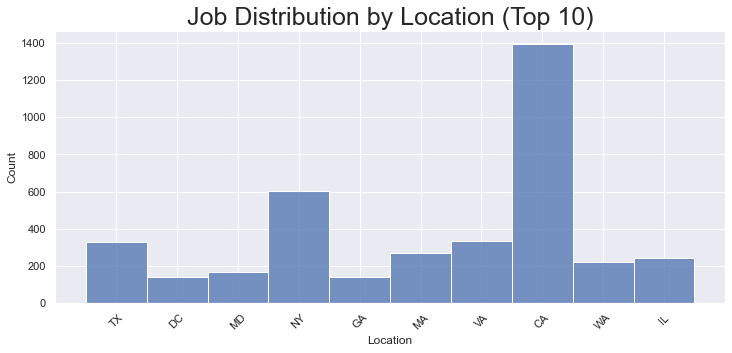

In [108]:
# The jobs are from different locations and not distributed evenly.
# Get the top 10 locations
top_locations = df['Location'].value_counts().head(10).index

# Filter the DataFrame to include only the top 10 locations
df_top_locations = df[df['Location'].isin(top_locations)]

# Set figure size for the plot
plt.figure(figsize=(12, 5))

# Create a histogram of the 'Location' column in the DataFrame
sns.histplot(df_top_locations['Location'])

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Set the title of the plot
plt.title('Job Distribution by Location (Top 10)', size=25)

# Show the plot
plt.show()

From the histogram, we can observe that the job postings are heavily concentrated in California (CA), with around 1400 listings. The next most common location, New York (NY), has only about 600 listings. The remaining eight locations in the top 10 each have around 300 listings.

This uneven distribution could be reflective of the tech industry's concentration in certain geographic regions, particularly California. However, for the purposes of this project, we are not considering location-specific variations in job skills. We are interested in extracting skills from job descriptions irrespective of their geographic location.

Next, let's examine the distribution of job titles in our dataset. Understanding the variety of job titles can give us insights into the diversity of jobs and, by extension, the range of skills that might be represented in our data.

In [109]:
# Display the top 10 most common job titles in the dataset
top_job_titles = df['Job_Title'].value_counts().head(10)
top_job_titles

Data Scientist              715
Data Analyst                405
Data Engineer               391
Senior Data Scientist       205
Senior Data Engineer        136
Senior Data Analyst          86
Big Data Engineer            80
Principal Data Scientist     62
Lead Data Scientist          49
Sr. Data Scientist           45
Name: Job_Title, dtype: int64

### Job Titles Distribution

The dataset contains a variety of job titles related to data science roles. Let's visualize the distribution of the top 10 job titles:



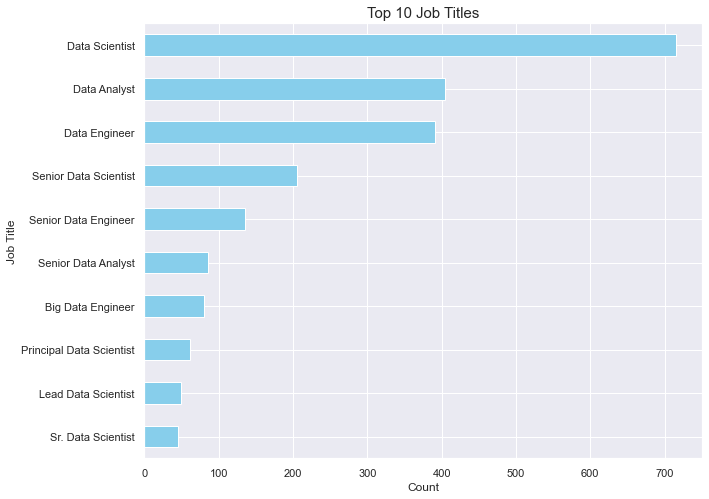

In [110]:
# Create a barplot for the top 10 job titles
plt.figure(figsize=(10,8))
top_job_titles.plot(kind='barh', color='skyblue')
plt.title('Top 10 Job Titles', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Job Title', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

 The job title alone may not reflect the true nature of the work involved. Job titles can vary widely across different companies, industries, and regions, and the same title can often encompass a range of responsibilities and skills. For a more accurate understanding of the skills required for different roles, a detailed analysis of the job descriptions and skills listed in the dataset would be needed.


# Preprocessing

Let's see a job description to get a sense of the data.

In [111]:
# Preprocessing
print("Preprocessing Step:")

# Displaying an example of a job description to get a sense of the data.
example_desc = df['Description'].iloc[0]

print("\nOriginal Job Description:")
print("--------------------------")
print(example_desc)

Preprocessing Step:

Original Job Description:
--------------------------
[<p><b>POSITION SUMMARY</b></p>, <p>
The Business Analyst role is the primary architect of reporting and dashboard solutions for internal and external clients. Utilizing ESI corporate standard development tools this position is responsible for the design, development, implementation, analysis, interpretation and communication of business information based on the needs of individual clients. The ability to balance overall aesthetics with robust and intuitive functionality is a critical requirement for success in this position.</p>, <p><b>
ESSENTIAL FUNCTIONS</b></p>, <ul><li>
Successfully design and implement external client data reporting and dashboard solutions with a strong focus on product aesthetics and functionality.</li><li>
Aid in the design, development, and implementation of new product ideas for external and internal clients.</li><li>
Maintain Live and Data Warehouse Business Objects Universes; add new 

We need to clean the data by removing irrelevant information.  

In [121]:
def clean_text(raw):
    '''Clean text from html tags, brackets, new lines, and duplicate whitespace.'''
    try:
        # remove new lines
        raw = raw.replace('\r', '')
        raw = raw.replace('\n', '')
        raw = raw.translate(str.maketrans('',''))
        
        # brackets appear in all instances
        raw = raw.replace('[', '')
        raw = raw.replace(']', '')
        raw = raw.replace(')', '')
        raw = raw.replace('(', '')
        
        # removing html tags
        clean_html = re.compile('<.*?>')
        clean_text = re.sub(clean_html, ' ', raw)
        
        # removing duplicate whitespace in between words
        clean_text = re.sub(" +", " ", clean_text) 
        
        # stripping first and last white space 
        clean_text = clean_text.strip()
        
        # commas had multiple spaces before and after in each instance
        clean_text = re.sub(" , ", ", ", clean_text) 
        
        # eliminating the extra comma after a period
        clean_text = clean_text.replace('.,', '.')
        
        # using try and except due to Nan in the column
    except:
        clean_text = np.nan
        
    return clean_text

## Text Preprocessing
The text data in the 'Description' column has been cleaned and preprocessed. Here's a brief summary of the steps taken:

1. **Removal of newline characters:** The newline characters (\r and \n) have been replaced with an empty space, essentially removing them.

2. **Removal of brackets:** All instances of square and round brackets have been removed from the text.

3. **Removal of HTML tags:** Any strings enclosed within "<" and ">" have been identified as HTML tags and removed.

4. **Whitespace correction:** Multiple spaces between words have been replaced with a single space, and leading/trailing whitespaces have been removed. Extra spaces around commas and after periods have also been fixed.

Now, let's examine a sample preprocessed job description:

In [122]:
df_desc = df.Description.apply(clean_text)
print(df_desc.iloc[0])

POSITION SUMMARY, The Business Analyst role is the primary architect of reporting and dashboard solutions for internal and external clients. Utilizing ESI corporate standard development tools this position is responsible for the design, development, implementation, analysis, interpretation and communication of business information based on the needs of individual clients. The ability to balance overall aesthetics with robust and intuitive functionality is a critical requirement for success in this position. ESSENTIAL FUNCTIONS, Successfully design and implement external client data reporting and dashboard solutions with a strong focus on product aesthetics and functionality. Aid in the design, development, and implementation of new product ideas for external and internal clients. Maintain Live and Data Warehouse Business Objects Universes; add new fields, modify table joins, implement data structures that streamline report extraction and data analysis. Develop and document best practic

In [123]:
# change the type from series to df and drop all missing values total: 301 missing descriptions
df_desc = pd.DataFrame(df_desc)

## Handling Missing Values
Next, we address missing values in our data. Specifically, we remove any job descriptions that are null. There are 301 such instances in our current dataset.

In [124]:
df_desc.dropna(inplace = True)

## Resetting Index
Post the removal of missing values, it's crucial to reset the index. This step ensures our dataframe's index is contiguous and aligns properly with the data, particularly helpful when referencing by index in the later stages.

In [125]:
df_desc.reset_index(inplace=True, drop=True)

We now have a clean dataframe ready for further processing and analysis.

In [113]:
print(f"The dataframe now contains {df_desc.shape[0]} job descriptions.")

The dataframe now contains 5715 job descriptions.


# Text Tokenization

Text tokenization is the process of breaking up the text into individual words, known as tokens. This step is important in our exploratory data analysis as it allows us to analyze the frequency and distribution of words within the job descriptions. 

We will use the `RegexpTokenizer` from NLTK, which splits the text into tokens using a regular expression. The advantage of `RegexpTokenizer` is that it will discard all non-word characters (punctuation, numerals, etc.) which aren't typically useful in our text analysis. 

We'll start by creating a new column with the lowercased version of the descriptions. Lowercasing the text is a common step in text preprocessing, ensuring that the same words in different cases aren't considered as different words (for example, 'Python' and 'python'). 

Finally, we'll apply the tokenizer to this lowercase text to create our tokens.

In [126]:
# create a temp column for lowercased description
df_desc['lower_description'] = df_desc.Description.str.lower()
# regexp tokenizer eliminates the punctuation for the word count and is faster than word_tokenizer
tokenizer = RegexpTokenizer(r"\w+")
df_desc['word_tokenized'] = df_desc.lower_description.apply(lambda row: tokenizer.tokenize(row))

### Word Frequency Distribution

To gain insights into the most common words used in the job descriptions, we can examine the word frequency distribution. Let's display the tokenized words from the first few descriptions as an example:


In [127]:
df_desc.word_tokenized.head()

0    [position, summary, the, business, analyst, ro...
1    [what, do, we, need, you, to, have, an, amazin...
2    [validate, analyze, and, conduct, statistical,...
3    [full, time, washington, dc, metro, area, star...
4    [assist, in, consultations, with, business, pa...
Name: word_tokenized, dtype: object

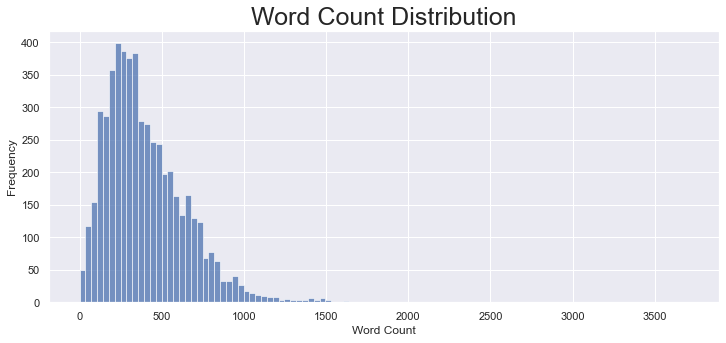

In [128]:
# obtains a word count for each individual job description 
df_desc['word_count'] = df_desc.word_tokenized.str.len()
plt.figure(figsize=(12, 5))
sns.histplot(df_desc['word_count'])
plt.title('Word Count Distribution', size=25)
plt.xlabel('Word Count', size=12)
plt.ylabel('Frequency', size=12)
plt.show()

The length of job descriptions vary. Longer job descriptions may provide more context and contextually rich information for identifying skills. On the other hand, shorter descriptions may require additional techniques, such as leveraging the surrounding context (e.g., job titles, requirements, bullet points) to improve skill extraction accuracy.

### Remove stop words

To further preprocess the job descriptions, we will tokenize the text and remove stop words. Tokenization involves breaking down the text into individual words or tokens, and stop word removal eliminates common words that often do not carry significant meaning in the context of our analysis.

We will be using the `en_core_web_sm` model from the spaCy library for tokenization and stop word removal. Here's the code:


In [130]:
def remove_stopwords(data):
    nlp = spacy.load('en_core_web_sm')
    data['word_tokenized'] = data['word_tokenized'].apply(lambda tokens: [token for token in tokens if not nlp.vocab[token].is_stop])
    return data

In [138]:
def generate_wordcloud(word_frequency):
    if len(word_frequency) == 0:
        print("No word frequencies found. Make sure the 'word_tokenized' column is populated.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='C:/Windows/Fonts/times.ttf')
    if len(word_frequency) > 0:
        wordcloud.generate_from_frequencies(word_frequency)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud', size=25)
        plt.show()
    else:
        print("No word frequencies found. Make sure the 'word_tokenized' column is populated.")


In [139]:
df_desc.head()

,Description,lower_description,word_tokenized,word_count
0,"POSITION SUMMARY, The Business Analyst role is...","position summary, the business analyst role is...","[position, summary, business, analyst, role, p...",424
1,"What do we need?, You to have an amazing perso...","what do we need?, you to have an amazing perso...","[need, amazing, personality, communication, st...",286
2,"Validate, analyze, and conduct statistical ana...","validate, analyze, and conduct statistical ana...","[validate, analyze, conduct, statistical, anal...",314
3,"Full time, Washington, DC metro area, Starting...","full time, washington, dc metro area, starting...","[time, washington, dc, metro, area, starting, ...",297
4,Assist in consultations with business partners...,assist in consultations with business partners...,"[assist, consultations, business, partners, in...",316


## Lemmatization

In [61]:
def lemming(text):
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(word) for word in text]
    return lemmed

df_desc['clean_lemmed'] = df_desc.clean_words.apply(lemming)

In [64]:
df_desc.word_tokenized

0       [position, summary, the, business, analyst, ro...
1       [what, do, we, need, you, to, have, an, amazin...
2       [validate, analyze, and, conduct, statistical,...
3       [full, time, washington, dc, metro, area, star...
4       [assist, in, consultations, with, business, pa...
                              ...                        
5408    [as, a, data, software, engineer, you, will, f...
5409    [want, to, change, the, world, how, about, con...
5410    [identify, and, solve, hybrid, cloud, data, en...
5411    [at, capital, one, we, re, building, a, leadin...
5412    [develops, parallel, data, intensive, systems,...
Name: word_tokenized, Length: 5413, dtype: object

In [69]:
df_desc.head()

,Description,lower_description,word_tokenized,word_count,clean_words,clean_lemmed
0,"POSITION SUMMARY, The Business Analyst role is...","position summary, the business analyst role is...","[position, summary, the, business, analyst, ro...",424,"[position, summary, business, analyst, role, p...","[position, summary, business, analyst, role, p..."
1,"What do we need?, You to have an amazing perso...","what do we need?, you to have an amazing perso...","[what, do, we, need, you, to, have, an, amazin...",286,"[need, amazing, personality, communication, st...","[need, amazing, personality, communication, st..."
2,"Validate, analyze, and conduct statistical ana...","validate, analyze, and conduct statistical ana...","[validate, analyze, and, conduct, statistical,...",314,"[validate, analyze, conduct, statistical, anal...","[validate, analyze, conduct, statistical, anal..."
3,"Full time, Washington, DC metro area, Starting...","full time, washington, dc metro area, starting...","[full, time, washington, dc, metro, area, star...",297,"[full, time, washington, dc, metro, area, star...","[full, time, washington, dc, metro, area, star..."
4,Assist in consultations with business partners...,assist in consultations with business partners...,"[assist, in, consultations, with, business, pa...",316,"[assist, consultations, business, partners, in...","[assist, consultation, business, partner, inte..."


## Training data
Using rule-based skill extraction is very cumbersome and every time a new example is added we might need to update the rules. This is where the machine learning shines. To use machine learning for this problem, first we need to create annotated training data. The best approach is annotating the data manually but here we use spaCy to annotate data. Other option is to use openai gpt3 to annotate the files.
Here is the code that shows how to do it.

```import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")
text = "I use python everyday"
prompt = "Extract skills from {text}"

completion = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    max_tokens=100,
    n=1,
    stop=None,
    temperature=0.7,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
)

print(completion.choices[0].text.strip())```

In [78]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import DocBin, Span
from spacy.language import Language

nlp = spacy.load("en_core_web_sm")
skill_patterns = []

# Read the list of skills from the file
with open('data/LINKEDIN_SKILLS_ORIGINAL.txt', 'r', encoding='utf-8') as f:
    for line in f:
        skill_patterns.append(nlp(line.strip().lower()))

matcher = PhraseMatcher(nlp.vocab)
matcher.add("SKILL", skill_patterns)

# Define the custom component
@Language.component("skill_component")
def skill_component_function(doc):
    matches = matcher(doc)
    matches = sorted(matches, key=lambda match: match[2] - match[1], reverse=True)
    seen_tokens = set()
    spans = []
    for match_id, start, end in matches:
        if any(token.i in seen_tokens for token in doc[start:end]):
            continue
        seen_tokens.update(range(start, end))
        span = Span(doc, start, end, label="SKILL")
        spans.append(span)
    doc.ents = spans
    return doc

In [79]:


# Add the custom component to the pipeline after the "ner" component
nlp.add_pipe("skill_component", after="ner")

# Process the DataFrame column and save the annotations using DocBin
docs = list(nlp.pipe(df_desc['lower_description'].values))
doc_bin = DocBin(docs=docs)
doc_bin.to_disk("annotated_file.spacy")

print("Annotations saved to annotated_file.spacy")
print(nlp.pipe_names)

Annotations saved to annotated_file.spacy
['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'skill_component']


# Splitting Data into Training and Test Sets

In order to evaluate the performance of our machine learning model, it is essential to have separate datasets for training and testing. The training set is used to train the model, while the test set is used to assess its performance on unseen data. By splitting the data into training and test sets, we can estimate how well our model generalizes to new data.

Here, we will split the annotated data into training and test sets, allocating 80% of the data to the training set and 20% to the test set. This is a common practice when working with limited data, as it allows us to have sufficient data for training while still reserving a portion for evaluation.

In [80]:
from sklearn.model_selection import train_test_split

# Load the original DocBin file
doc_bin = DocBin().from_disk("annotated_file.spacy")

# Convert DocBin to list of Doc objects
docs = list(doc_bin.get_docs(nlp.vocab))

# Split the data into train and test sets
train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=42)

# Create DocBins for train and test sets
train_doc_bin = DocBin(docs=train_docs)
test_doc_bin = DocBin(docs=test_docs)

# Save the train and test DocBins
train_doc_bin.to_disk("data/train_data.spacy")
test_doc_bin.to_disk("data/test_data.spacy")

# Machine Learning Model

Rule-based matching for skills is not ideal for generalizing because it relies on predefined patterns and may struggle with unseen data. To achieve better performance and adaptability, machine learning is the preferred approach. In this case, we utilize spaCy, specifically its pipelines for `tok2vec` and `ner`, to train a model capable of predicting and extracting skills.

`tok2vec` is a powerful component in spaCy's pipeline due to its contextual understanding, making it superior in terms of semantic similarity compared to Word2Vec, another popular word embedding method. Moreover, contextual embeddings can be pretrained on domain-specific data, enabling them to capture domain-specific language patterns and enhance performance on specific domains or tasks.

We store the hyperparameters and configurations in the `config.cfg` file. For this model, we have chosen a learning rate of 0.001, Adam optimizer, and a dropout rate of 0.1. However, to further optimize the model's performance, it is crucial to conduct hyperparameter tuning. This involves trying different combinations of hyperparameters and performing grid search to identify the best parameter set that yields optimal results.

To facilitate hyperparameter tuning, we split the data into training, development, and testing sets, allocating 60% for training, 20% for development, and 20% for testing. Through iterative experimentation, we can assess the model's performance with various parameter configurations and select the most effective one.

Given that this is a prototype and proof of concept, our focus will primarily be on developing and evaluating the model.

In [81]:
!python -m spacy init fill-config data/base_config.cfg data/config.cfg

✔ Auto-filled config with all values
✔ Saved config
data\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [83]:
!python -m spacy train data/config.cfg --output ./output --paths.train data/train_data.spacy --paths.dev data/test_data.spacy

ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    111.67    3.35    3.03    3.73    0.03
  0     200        353.99  12909.47   80.87   85.79   76.48    0.81
  0     400        344.26   5441.83   84.44   85.69   83.23    0.84
  0     600        324.30   4464.79   86.28   91.33   81.76    0.86
  0     800        306.16   4126.24   86.59   87.22   85.98    0.87
  0    1000        252.85   3166.26   89.40   91.04   87.82    0.89
  0    1200        284.27   3018.98   90.23   91.81   88.71    0.90
  0    1400        265.48   2787.42   90.45   92.34   88.63    0.90
  0    1600        279.25   289

[2023-05-18 07:24:26,337] [INFO] Set up nlp object from config
[2023-05-18 07:24:26,348] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-05-18 07:24:26,352] [INFO] Created vocabulary
[2023-05-18 07:24:26,352] [INFO] Finished initializing nlp object
[2023-05-18 07:24:49,218] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


The result of skill extraction using spaCy shows an improvement in performance over multiple iterations. The evaluation metrics, such as ENTS_F, ENTS_P, ENTS_R, and SCORE, indicate the accuracy and precision of the extracted skills.

Based on the results, the model achieves an F1 score of around 97% after 5,000 iterations, indicating that it performs well in identifying and extracting skills from the text.

## Evaluate the model

Test the job description of Fuel50 for the AI engineer.

In [144]:
nlp = spacy.load('output/model-best')
file = open('data/LINKEDIN_SKILLS_ORIGINAL.txt', 'r', encoding='utf-8')
with open('data/test_job_description.csv', 'r') as f:
    text = f.read()
doc = nlp(text)
          
for ent in doc.ents:
    print(ent.text)

cloud
SaaS
career pathing
mobility
agile
artificial intelligence
machine learning
career pathing
engage
Artificial Intelligence
SaaS
application
range
artificial intelligence
scientists
software engineers
artificial intelligence
models
architecture
troubleshooting
models
business requirements
artificial Intelligence
artificial intelligence
thought leadership
articulate
Agile environment
market analysis
building
Design
artificial intelligence
models
algorithms
user experience
drive
business value
scalability
scientists
models
pipelines
infrastructure
models
scientists
engineers
business requirements
models
models
visualization
data processing
training
developments
machine learning
training
workshops
clear
teams
Computer Science
Mathematics
Statistics
Data Science
artificial intelligence
record
Python
scikit-learn
hypothesis testing
experimental design
data processing
data analysis
data visualization
Pandas
NumPy
Matplotlib
computing
AWS
Hadoop
Spark
plus
version control
testing
continuo

After reviewing the extracted entities, it appears that some of them may not represent skills in the context of the job description. This could be due to limitations in the model or the ambiguity of certain terms. To address this, you can consider the following approaches:

1. Custom Filtering: Manually review the extracted entities and create a custom filtering mechanism to remove non-skills based on your specific criteria. This can involve defining a list of stop words or non-skills and filtering out any entities that match those words.

2. Additional Training Data: Expand your training data with more annotated examples, including both positive (skills) and negative (non-skills) examples. This will help the model learn to differentiate between skills and non-skills more effectively.

3. Fine-tuning the Model: Fine-tuning the pre-trained model with domain-specific data or additional training can enhance its performance in skill extraction. By exposing the model to more relevant examples from your specific domain, it can learn to recognize skills more accurately.

4. Hybrid Approach: Consider combining the rule-based matching approach with the machine learning model. After extracting skills using the model, apply additional rules or heuristics to filter out non-skills based on specific patterns or criteria.

It is crucial to iterate and experiment with these approaches to find the best solution for your particular use case. By refining the skill extraction process, you can improve the accuracy and relevance of the extracted skills for your job descriptions.

Upon obtaining the results, it is essential to analyze the confusion matrix to gain insights into the model's performance. By examining the false positives and false negatives, we can identify areas for improvement. There are several approaches we can explore to enhance the model.

Firstly, we can consider incorporating additional rules into the model to refine its predictions. These rules can help address specific patterns or exceptions that the model may struggle with, leading to improved accuracy.

Secondly, leveraging a high-quality, comprehensive dataset can significantly impact the model's performance. By obtaining a well-curated and diverse dataset, we can provide the model with a more robust and representative sample, leading to better generalization and prediction capabilities.

Additionally, transformer-based models, such as BERT, offer promising avenues for improvement. These models leverage advanced architectures and pre-trained contextual embeddings to capture intricate language patterns and semantic relationships effectively. Incorporating such models into the pipeline can potentially enhance the accuracy and overall performance of the skill extraction system.

In summary, to enhance the model's performance, we can consider integrating additional rules, utilizing high-quality data, and exploring transformer-based models like BERT. By iteratively refining the system and leveraging these approaches, we can achieve better skill extraction results and improve overall accuracy.

## Classifying skills

We label the skills and then encode the labels, use word embedding, and then we use transfer learning with BERT to train a model

In [102]:
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Load and preprocess the data
with open('data/hard_skills/technical.txt', 'r', encoding='utf-8') as f:
    hard_skills = [line.strip() for line in f.readlines()]

with open('data/soft_skills/soft_skills0.txt', 'r', encoding='utf-8') as f:
    soft_skills = [line.strip() for line in f.readlines()]

hard_skills_df = pd.DataFrame({'skill': hard_skills, 'label': 1})
soft_skills_df = pd.DataFrame({'skill': soft_skills, 'label': 0})

data = pd.concat([hard_skills_df, soft_skills_df], ignore_index=True)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the input data
train_encodings = tokenizer(list(train_data['skill']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_data['skill']), truncation=True, padding=True)

# Convert tokenized inputs to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_data['label'].values))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_data['label'].values))

# Define the optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
model.train()
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)
accuracy = total_correct / total_samples

print(f"Accuracy on test set: {accuracy}")

c:\Users\egha355\Envs\datascience\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\egha355\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Accuracy on test set: 0.9908749329039184


After achieving an accuracy of 99.09% on the test set, it is crucial to thoroughly analyze and discuss the results to ensure the model's performance is reliable and robust. Here are some key points to consider:

Dataset Quality: Evaluate the quality of the labeled data used for training and testing the model. Ensure that the dataset is representative of the skills you want to classify and that the labeling process was accurate and consistent. Any issues with the dataset quality can impact the model's performance.

Data Leakage: Investigate the possibility of data leakage, where information from the test set might have leaked into the training process, leading to inflated performance metrics. Ensure that the train-test split was done properly and that there was no overlap or unintentional information transfer between the two sets.

Generalization: Assess how well the model generalizes to unseen data. Consider conducting additional evaluations, such as cross-validation or using an independent validation set, to measure the model's performance on different data samples. This will provide a more robust estimation of the model's accuracy and its ability to handle new, unseen instances.

False Positives and False Negatives: Examine the model's performance in terms of false positives and false negatives. False positives are instances where the model incorrectly classifies a non-skill as a skill, while false negatives occur when the model fails to identify an actual skill. Understanding these errors can help identify areas for improvement and guide future iterations of the model.

Model Optimization: Consider fine-tuning the model and exploring different hyperparameter settings to achieve even better performance. Adjusting the learning rate, batch size, or optimizer can have an impact on the model's accuracy and convergence speed. Additionally, you can experiment with different architectures or pre-trained models to enhance the classification capabilities.

Error Analysis: Perform a thorough error analysis to understand the types of skills that the model struggles with. Identify patterns and common characteristics of misclassified skills. This analysis can help identify potential limitations of the model and guide further improvements.

Feedback Loop: Establish a feedback loop to continuously improve the model's performance. Collect feedback from users or domain experts to refine the skill classification system. Incorporate their insights to iteratively enhance the model's accuracy and address any specific challenges or nuances in skill classification.

By addressing these considerations and continuously iterating and improving the model based on feedback and evaluation, you can enhance the skill classification system and ensure its reliability and usefulness in practical applications.

# Resume dataset

To show a prototype for skill extraction, I just did it on the job postings dataset that showed how it works. We could add resume data to the JPs but we should consider they shouldn't be imbalance otherwise the model learns one of them more than the other. we could do resume separetely as there are some rules to find different segments of the resume and get the relevant phrases. If we want to do it separately we can benefit from the rules below that extracts the skill segment. The code inspired by https://github.com/kbrajwani/resume_parser.git

In [ ]:

from __future__ import division
import nltk

import re
import os
from datetime import date

import nltk
import docx2txt
import pandas as pd
from tika import parser

import logging

import spacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher

import sys
import operator
import string
import nltk

# load pre-trained model
base_path = os.path.dirname(__file__)

nlp = spacy.load('en_core_web_sm')

file = os.path.join(base_path,"LINKEDIN_SKILLS_ORIGINAL.txt")
file = open(file, "r", encoding='utf-8')    
skill = [line.strip().lower() for line in file]
skillsmatcher = PhraseMatcher(nlp.vocab)
patterns = [nlp.make_doc(text) for text in skill if len(nlp.make_doc(text)) < 10]
skillsmatcher.add("Job title", None, *patterns)


class SkillExtractor:
    skills_header = (
        'credentials',
        'areas of experience',
        'areas of expertise',
        'areas of knowledge',
        'skills',
        "other skills",
        "other abilities",
        'career related skills',
        'professional skills',
        'specialized skills',
        'technical skills',
        'computer skills',
        'personal skills',
        'computer knowledge',        
        'technologies',
        'technical experience',
        'proficiencies',
        'languages',
        'language competencies and skills',
        'programming languages',
        'competencies'
    )

           
    def convert_docx_to_txt(docx_file,docx_parser):
        """
            A utility function to convert a Microsoft docx files to raw text.

            This code is largely borrowed from existing solutions, and does not match the style of the rest of this repo.
            :param docx_file: docx file with gets uploaded by the user
            :type docx_file: InMemoryUploadedFile
            :return: The text contents of the docx file
            :rtype: str
        """
        try:
          if docx_parser == "tika":
            text = parser.from_file(docx_file, service='text')['content']
          elif docx_parser == "docx2txt":
            text = docx2txt.process(docx_file)
          else:
            logging.error('Choose docx_parser from tika or docx2txt :: ' + str(e)+' is not supported')
            return [], " "
        except RuntimeError as e:            
            logging.error('Error in tika installation:: ' + str(e))
            logging.error('--------------------------')
            logging.error('Install java for better result ')
            text = docx2txt.process(docx_file)
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "
        try:
            clean_text = re.sub(r'\n+', '\n', text)
            clean_text = clean_text.replace("\r", "\n").replace("\t", " ")  # Normalize text blob
            resume_lines = clean_text.splitlines()  # Split text blob into individual lines
            resume_lines = [re.sub('\s+', ' ', line.strip()) for line in resume_lines if
                            line.strip()]  # Remove empty strings and whitespaces
            return resume_lines, text
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "

    def convert_pdf_to_txt(pdf_file):
        """
        A utility function to convert a machine-readable PDF to raw text.

        This code is largely borrowed from existing solutions, and does not match the style of the rest of this repo.
        :param input_pdf_path: Path to the .pdf file which should be converted
        :type input_pdf_path: str
        :return: The text contents of the pdf
        :rtype: str
        """
            
        try:
            raw_text = parser.from_file(pdf_file, service='text')['content']
        except RuntimeError as e:            
            logging.error('Error in tika installation:: ' + str(e))
            logging.error('--------------------------')
            logging.error('Install java for better result ')
            pdf = pdfplumber.open(pdf_file)
            raw_text= ""
            for page in pdf.pages:
              raw_text += page.extract_text() + "\n"
            pdf.close()                
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "
        try:
            full_string = re.sub(r'\n+', '\n', raw_text)
            full_string = full_string.replace("\r", "\n")
            full_string = full_string.replace("\t", " ")

            # Remove awkward LaTeX bullet characters

            full_string = re.sub(r"\uf0b7", " ", full_string)
            full_string = re.sub(r"\(cid:\d{0,2}\)", " ", full_string)
            full_string = re.sub(r'• ', " ", full_string)

            # Split text blob into individual lines
            resume_lines = full_string.splitlines(True)

            # Remove empty strings and whitespaces
            resume_lines = [re.sub('\s+', ' ', line.strip()) for line in resume_lines if line.strip()]

            return resume_lines, raw_text
        except Exception as e:
            logging.error('Error in docx file:: ' + str(e))
            return [], " "
            
    def find_segment_indices(string_to_search, resume_segments, resume_indices):
        for i, line in enumerate(string_to_search):

            if line[0].islower():
                continue

            header = line.lower()

            if [s for s in SkillExtractor.skills_header if header.startswith(s)]:
                try:
                    resume_segments['skills'][header]
                except:
                    resume_indices.append(i)
                    header = [s for s in SkillExtractor.skills_header if header.startswith(s)][0]
                    resume_segments['skills'][header] = i


    def slice_segments(string_to_search, resume_segments, resume_indices):
        resume_segments['contact_info'] = string_to_search[:resume_indices[0]]

        for section, value in resume_segments.items():
            if section == 'contact_info':
                continue

            for sub_section, start_idx in value.items():
                end_idx = len(string_to_search)
                if (resume_indices.index(start_idx) + 1) != len(resume_indices):
                    end_idx = resume_indices[resume_indices.index(start_idx) + 1]

                resume_segments[section][sub_section] = string_to_search[start_idx:end_idx]

    def segment(string_to_search):
        resume_segments = {
            'objective': {},
            'work_and_employment': {},
            'education_and_training': {},
            'skills': {},
            'accomplishments': {},
            'misc': {}
        }

        resume_indices = []

        SkillExtractor.find_segment_indices(string_to_search, resume_segments, resume_indices)
        if len(resume_indices) != 0:
            SkillExtractor.slice_segments(string_to_search, resume_segments, resume_indices)
        else:
            resume_segments['contact_info'] = []

        return resume_segments
    
    def extract_skills(text):

        skills = []

        __nlp = nlp(text.lower())
        # Only run nlp.make_doc to speed things up

        matches = skillsmatcher(__nlp)
        for match_id, start, end in matches:
            span = __nlp[start:end]
            skills.append(span.text)
        skills = list(set(skills))
        return skills


    def get_skills(file,docx_parser = "tika"):
        """
        file : Give path of resume file
        docx_parser : Enter docx2txt or tika, by default is tika
        """
        # file = "/content/Asst Manager Trust Administration.docx"
        file = os.path.join(file)
        if file.endswith('docx') or file.endswith('doc'):
            if file.endswith('doc') and docx_parser == "docx2txt":
              docx_parser = "tika"
              logging.error("doc format not supported by the docx2txt changing back to tika")
            resume_lines, raw_text = SkillExtractor.convert_docx_to_txt(file,docx_parser)
        elif file.endswith('pdf'):
            resume_lines, raw_text = SkillExtractor.convert_pdf_to_txt(file)
        elif file.endswith('txt'):
            with open(file, 'r', encoding='latin') as f:
                resume_lines = f.readlines()

        else:
            resume_lines = None
        resume_segments = SkillExtractor.segment(resume_lines)
        
        
        full_text = " ".join(resume_lines)

        email = SkillExtractor.extract_email(full_text)
        phone = SkillExtractor.find_phone(full_text)
        name = SkillExtractor.extract_name(" ".join(resume_segments['contact_info']))
        total_exp, text = SkillExtractor.get_experience(resume_segments)
        university = SkillExtractor.extract_university(full_text, os.path.join(base_path,'world-universities.csv'))

        designition = SkillExtractor.job_designition(full_text)
        designition = list(dict.fromkeys(designition).keys())

        degree = SkillExtractor.get_degree(full_text)
        company_working = SkillExtractor.get_company_working(full_text)
        
        skills = ""

        if len(resume_segments['skills'].keys()):
            for key , values in resume_segments['skills'].items():
              skills += re.sub(key, '', ",".join(values), flags=re.IGNORECASE)            
            skills = skills.strip().strip(",").split(",")
        
        if len(skills) == 0:
            skills = SkillExtractor.extract_skills(full_text)
        skills = list(dict.fromkeys(skills).keys())
        
        return {
            "email": email,
            "phone": phone,
            "name": name,
            "total_exp": total_exp,
            "university": university,
            "designition": designition,
            "degree": degree,
            "skills": skills,
            "Companies worked at": company_working
        }

## conclusion
In conclusion, we have developed a prototype skill extraction system for job postings using a combination of rule-based matching and machine learning techniques. The system demonstrates promising results, achieving a high accuracy in identifying and extracting skills from job descriptions. We have discussed the limitations and challenges of the current approach, particularly in handling resumes, and identified areas for future work.

Given enough time and resources, there are several avenues to further improve and expand the system:

1. **Resume Parsing**: Develop a separate module specifically designed for parsing and extracting skills from resumes. This could involve leveraging existing rule-based approaches or exploring advanced techniques such as natural language processing and machine learning algorithms tailored for resume analysis.

2. **Fine-tuning the ML Model**: Fine-tune the machine learning model using a larger and more diverse dataset that includes job postings and resumes. This will help improve the model's generalization capabilities and enhance its performance in handling real-world data.

3. **Hyperparameter Optimization**: Conduct extensive hyperparameter tuning to identify the optimal configuration for the machine learning model. This could involve techniques such as grid search, random search, or Bayesian optimization to find the best combination of hyperparameters that maximize the model's performance.

4. **Domain-specific Customization**: Consider customizing the skill extraction system for specific domains or industries. This could involve incorporating domain-specific ontologies, dictionaries, or knowledge bases to enhance the system's understanding of domain-specific skills and terminology.

5. **Continuous Training and Evaluation**: Implement a pipeline for continuous model training and evaluation. As new job postings and resumes become available, regularly update the training data and retrain the model to ensure it stays up to date and maintains high performance.

6. **Integration with Other HR Systems**: Explore the integration of the skill extraction system with other HR systems such as applicant tracking systems (ATS) or talent management platforms. This integration can provide added value by automating the skill matching process, assisting in candidate screening, and facilitating skill-based job matching.

By addressing these aspects, we can further enhance the skill extraction system's accuracy, scalability, and adaptability, making it a valuable tool for HR professionals and job seekers alike.